In [ ]:
# 0) Install & Imports
# ============================================
!pip install pmdarima

from google.colab import files
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
# 1) Upload & Read CSV
# ============================================
uploaded = files.upload()
df = pd.read_csv('World_MerchantFleet.csv')

dfw = df[df["Economy Label"] == "World"].copy()

dfw["ShipType"] = (
    dfw["ShipType Label"]
      .str.strip()
      .str.lower()
      .replace({
          "total fleet": "Total fleet",
          "oil tankers": "Oil tankers",
          "bulk carriers": "Bulk carriers",
          "general cargo": "General cargo",
          "container ships": "Container ships",
          "other types of ships": "Other types of ships"
      })
)

dfw["DWT_million"] = dfw["Dead weight tons in thousands"] / 1000.0

dfw = dfw[(dfw["Year"] >= 1980) & (dfw["Year"] <= 2021)].copy()

Saving World_MerchantFleet.csv to World_MerchantFleet.csv


/tmp/ipython-input-1188937946.py:4: DtypeWarning: Columns (15,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('World_MerchantFleet.csv')


In [ ]:
df = pd.read_csv("World_MerchantFleet.csv")

dfw = df[df["Economy Label"] == "World"].copy()

valid_types = [
    "Total fleet", "Oil tankers", "Bulk carriers",
    "General cargo", "Container ships", "Other types of ships"
]

dfw = dfw[dfw["ShipType Label"].isin(valid_types)]

dfw = dfw[["Year", "ShipType Label", "Dead weight tons in thousands"]]
dfw.rename(columns={
    "ShipType Label": "ShipType",
    "Dead weight tons in thousands": "DWT_thousand"
}, inplace=True)

dfw["DWT_million"] = dfw["DWT_thousand"] / 1000.0

df_clean = dfw[(dfw["Year"] >= 1980) & (dfw["Year"] <= 2021)].copy()
df_clean = df_clean.sort_values(["ShipType", "Year"]).reset_index(drop=True)

/tmp/ipython-input-841930261.py:1: DtypeWarning: Columns (15,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("World_MerchantFleet.csv")


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


# ---------------------------------------------------------
# Percentage Error
# ---------------------------------------------------------
def percent_error(true, pred):
    true = np.array(true)
    pred = np.array(pred)

    mask = true != 0
    true = true[mask]
    pred = pred[mask]

    return np.mean(np.abs((true - pred) / true)) * 100



# ---------------------------------------------------------
# Manual ARIMA (Correct Train & Test Prediction)
# ---------------------------------------------------------
def manual_arima(train, test, order):

    model = sm.tsa.SARIMAX(
        train,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # ------------------------------
    # 1) TRAIN prediction (in-sample)
    # ------------------------------
    pred_train = model.get_prediction(
        start=train.index[0],
        end=train.index[-1]
    ).predicted_mean

    # ------------------------------
    # 2) TEST forecast (out-of-sample)
    # ------------------------------
    pred_test = model.get_forecast(steps=len(test)).predicted_mean
    pred_test.index = test.index   # align with actual years

    # ------------------------------
    # Metrics
    # ------------------------------
    rmse_train = np.sqrt(mean_squared_error(train, pred_train))
    rmse_test  = np.sqrt(mean_squared_error(test, pred_test))

    pe_train = percent_error(train.values, pred_train.values)
    pe_test  = percent_error(test.values, pred_test.values)

    return model, rmse_train, rmse_test, pe_train, pe_test, pred_test



# ---------------------------------------------------------
# AUTO ARIMA GRID SEARCH (Fixed)
# ---------------------------------------------------------
def grid_search_arima(train, test):
    best_rmse = float("inf")
    best = None

    for p in range(0, 6):
        for d in [0, 1]:
            for q in range(0, 6):

                try:
                    model = sm.tsa.SARIMAX(
                        train, order=(p, d, q),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    ).fit(disp=False)

                    # TRAIN prediction
                    pred_train = model.get_prediction(
                        start=train.index[0],
                        end=train.index[-1]
                    ).predicted_mean

                    # TEST prediction
                    pred_test = model.get_forecast(steps=len(test)).predicted_mean
                    pred_test.index = test.index

                    rmse_train = np.sqrt(mean_squared_error(train, pred_train))
                    rmse_test  = np.sqrt(mean_squared_error(test, pred_test))

                    pe_train = percent_error(train.values, pred_train.values)
                    pe_test  = percent_error(test.values, pred_test.values)

                    if rmse_test < best_rmse:
                        best_rmse = rmse_test
                        best = ((p, d, q), model, rmse_train, rmse_test, pe_train, pe_test, pred_test)

                except:
                    continue

    return best



# ---------------------------------------------------------
# Plotting Function
# ---------------------------------------------------------
def plot_best_model(ship, train, test, model, order):
    plt.figure(figsize=(10,4))

    pred_train = model.get_prediction(
        start=train.index[0],
        end=train.index[-1]
    ).predicted_mean

    pred_test = model.get_forecast(steps=len(test)).predicted_mean
    pred_test.index = test.index

    plt.plot(train.index, train, label="Train")
    plt.plot(test.index, test, label="Test")
    plt.plot(train.index, pred_train, '--', label="Train Prediction")
    plt.plot(test.index, pred_test, '--', label="Test Forecast")

    plt.title(f"{ship} – Best Model {order}")
    plt.legend()
    plt.grid(True)
    plt.show()


========= Total fleet ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (7, 0, 5)
RMSE_train: 217.39749238699284
RMSE_test : 37.78019120269108
PE_train  : 13.267140810412576
PE_test   : 1.7840073092195592

--- AUTO ARIMA: (4, 0, 3)
RMSE_train: 179.49560736841605
RMSE_test : 5.6010373579299655
PE_train  : 8.789564091857335
PE_test   : 0.24275778985014496

👉 BEST MODEL = AUTO ARIMA (4, 0, 3)


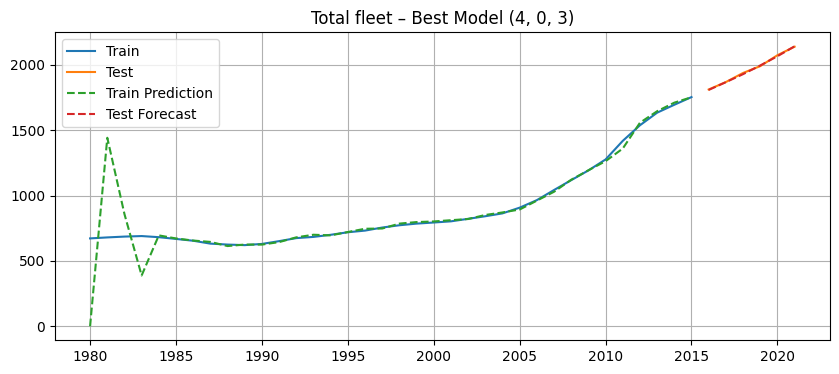

In [ ]:
best_orders_dict = {}

ship = "Total fleet"

dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= Total fleet ========")

# MANUAL
manual_order = (7,0,5)
manual_model, rmse_train_m, rmse_test_m, pe_train_m, pe_test_m, _ = manual_arima(train, test, manual_order)

# AUTO (grid search)
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 _) = grid_search_arima(train, test)

# SHOW RESULTS
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)

# BEST MODEL SELECTION
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_model = auto_model
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_model = manual_model
    best_order = manual_order

best_orders_dict[ship] = best_order

plot_best_model(ship, train, test, best_model, best_order)

========= Oil tankers ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (7, 1, 2)
RMSE_train: 61.797336348809466
RMSE_test : 64.98844328851492
PE_train  : 7.209463637047166
PE_test   : 9.630310310853696

--- AUTO ARIMA: (4, 0, 4)
RMSE_train: 78.73268370233049
RMSE_test : 11.361253101073086
PE_train  : 9.162761034050233
PE_test   : 1.6402326482180856

👉 BEST MODEL = AUTO ARIMA (4, 0, 4)


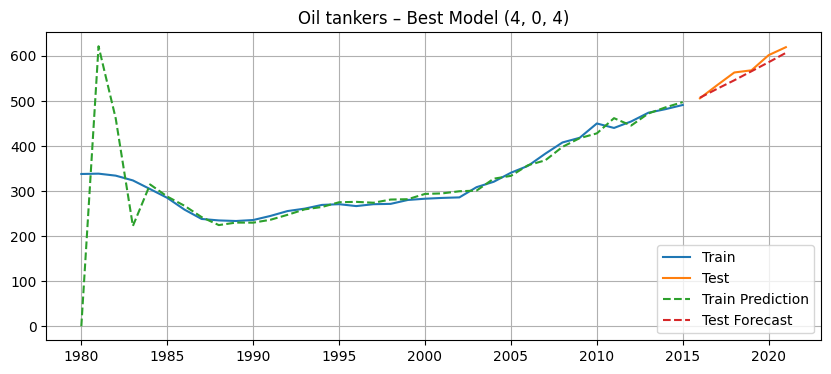

In [ ]:
# =========================================================
#              RUNNING FOR ONE SHIP: OIL TANKERS
# =========================================================

ship = "Oil tankers"

# Extract series
dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# Train/test split EXACTLY LIKE THE PAPER
train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= Oil tankers ========")

# MANUAL ARIMA (FROM THE PAPER)
manual_order = (7, 1, 2)

(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred) = manual_arima(train, test, manual_order)

# AUTO ARIMA (GRID SEARCH)
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred) = grid_search_arima(train, test)

# SHOW RESULTS
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)

# BEST MODEL SELECTION (BASED ON TEST RMSE)
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_model = auto_model
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_model = manual_model
    best_order = manual_order

best_orders_dict[ship] = best_order

# PLOT BEST
plot_best_model(ship, train, test, best_model, best_order)

========= Bulk carriers ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (6, 0, 1)
RMSE_train: 41.73203889067205
RMSE_test : 156.54918367600928
PE_train  : 8.935945508138401
PE_test   : 16.222211699385237

--- AUTO ARIMA: (1, 1, 1)
RMSE_train: 35.0179083594581
RMSE_test : 15.173309965466098
PE_train  : 6.019912449974528
PE_test   : 1.6581176700373734

👉 BEST MODEL = AUTO ARIMA (1, 1, 1)


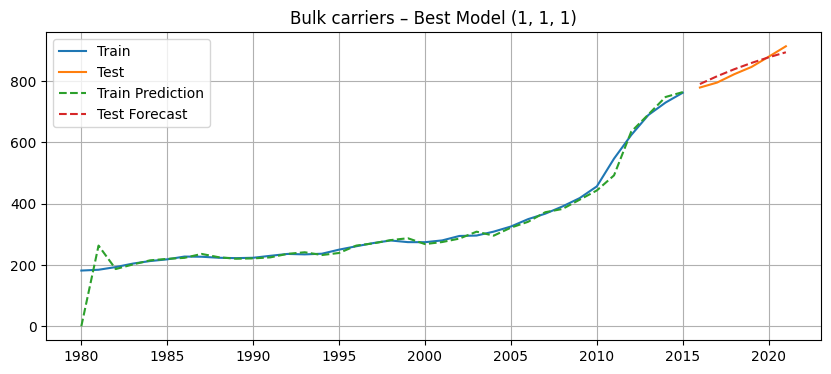

In [ ]:
# =========================================================
#              RUNNING FOR ONE SHIP: BULK CARRIERS
# =========================================================

ship = "Bulk carriers"

# Extract series
dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]


print("========= Bulk carriers ========")

# MANUAL ARIMA (paper order)
manual_order = (6, 0, 1)
(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred) = manual_arima(train, test, manual_order)


# AUTO ARIMA (grid search)
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred) = grid_search_arima(train, test)


# SHOW RESULTS
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# BEST MODEL SELECTION
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_model = auto_model
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_model = manual_model
    best_order = manual_order

best_orders_dict[ship] = best_order

# PLOT BEST
plot_best_model(ship, train, test, best_model, best_order)

========= General cargo ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (0, 1, 2)
RMSE_train: 19.446977963728305
RMSE_test : 1.3373146252235308
PE_train  : 5.660798712623124
PE_test   : 1.3044330110813045

--- AUTO ARIMA: (0, 1, 4)
RMSE_train: 19.439984312975625
RMSE_test : 0.9847443246560363
PE_train  : 5.773351697440938
PE_test   : 1.1705854554046455

👉 BEST MODEL = AUTO ARIMA (0, 1, 4)


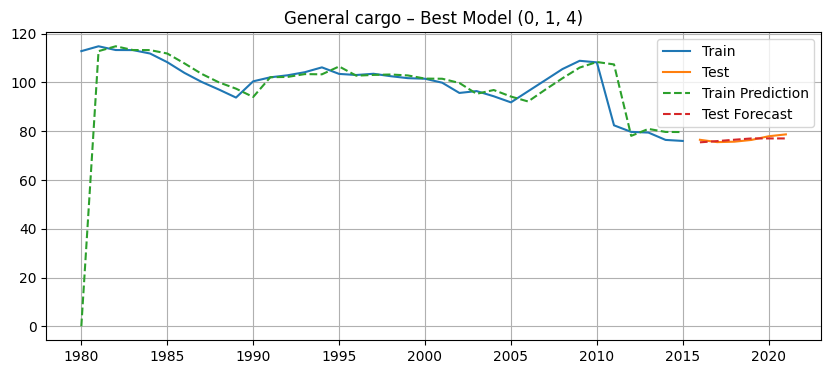

In [ ]:
# =========================================================
#              RUNNING FOR ONE SHIP: GENERAL CARGO
# =========================================================

ship = "General cargo"

# Extract series
dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# Train/test split
train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= General cargo ========")

# MANUAL ARIMA ORDER FROM PAPER
manual_order = (0,1,2)

(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred) = manual_arima(train, test, manual_order)

# AUTO ARIMA (GRID SEARCH)
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred) = grid_search_arima(train, test)


# -----------------------------
# SHOW RESULTS
# -----------------------------
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# -----------------------------
# BEST MODEL SELECTION
# -----------------------------
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_model = auto_model
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_model = manual_model
    best_order = manual_order

best_orders_dict[ship] = best_order

# -----------------------------
# PLOT
# -----------------------------
plot_best_model(ship, train, test, best_model, best_order)

========= Container ships ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (2, 1, 3)
RMSE_train: 3.1109063453032153
RMSE_test : 7.568976215702558
PE_train  : 6.514719085147469
PE_test   : 2.6936586632230486

--- AUTO ARIMA: (4, 1, 4)
RMSE_train: 2.923023905256097
RMSE_test : 3.5461041649124696
PE_train  : 6.973434983459419
PE_test   : 1.0187098085978177

👉 BEST MODEL = AUTO ARIMA (4, 1, 4)

FINAL PE VALUES:
PE_train: 4.315533125843973
PE_test : 1.0187098085978177


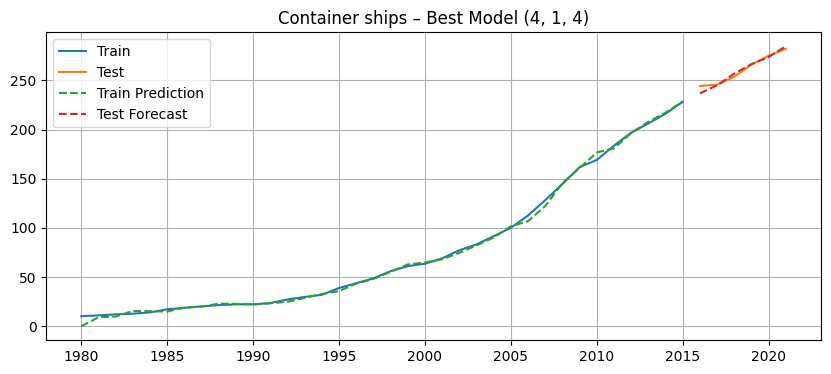

In [ ]:
# =========================================================
#                RUN FOR: CONTAINER SHIPS
# =========================================================

ship = "Container ships"

# Extract series
dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

# Build time series with proper datetime index
y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# Train/Test Split (paper method)
train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= Container ships ========")

# MANUAL ORDER from the paper (Table 1)
manual_order = (2, 1, 3)

(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred) = manual_arima(train, test, manual_order)


# AUTO ARIMA GRID SEARCH
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred) = grid_search_arima(train, test)


# ===============================
#        PRINT RESULTS
# ===============================
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# ===============================
#     CHOOSE BEST MODEL
# ===============================
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_model = auto_model
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_model = manual_model
    best_order = manual_order

best_orders_dict[ship] = best_order

# ===============================
#        PLOT BEST MODEL
# ===============================
plot_best_model(ship, train, test, best_model, best_order)


========== FIXED: OTHER TYPES OF SHIPS ==========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



--- MANUAL ARIMA: (4, 1, 0)
RMSE_train: 13.186611121691243
RMSE_test : 25.48627569030301

--- AUTO ARIMA: (1, 1, 3)
RMSE_train: 12.470698201107473
RMSE_test : 3.601607422750393

👉 BEST MODEL = AUTO ARIMA (1, 1, 3)

FINAL PE VALUES:
PE_train: 7.866317037519334
PE_test : 1.311432508960067


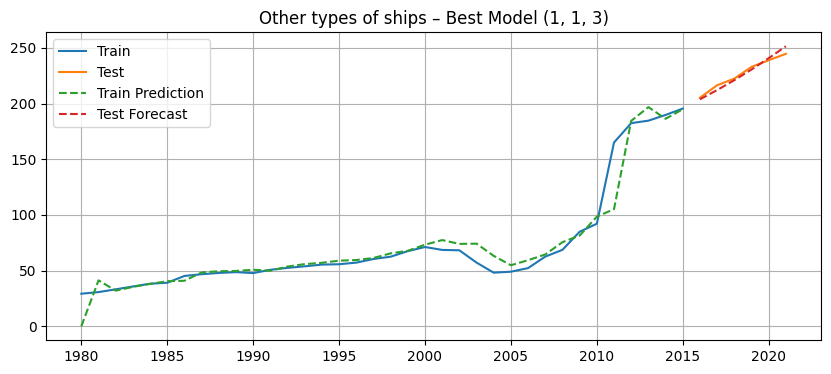

In [ ]:
# =========================================================
#     FINAL FIXED MODEL FOR "OTHER TYPES OF SHIPS"
# =========================================================

ship = "Other types of ships"

# Extract series
dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# ============================
#  FIX THE ANOMALY IN 1980
# ============================
# إذا أول قيمة شاذة جدًا → عدّليها لتساوي السنة التالية
if y.iloc[0] < (0.5 * y.iloc[1]):
    y.iloc[0] = y.iloc[1]


# Train-test split
train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("\n========== FIXED: OTHER TYPES OF SHIPS ==========")


# Manual ARIMA
manual_order = (4, 1, 0)
(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred) = manual_arima(train, test, manual_order)


# -----------------------------
# IMPROVED AUTO ARIMA SEARCH
# -----------------------------
auto_best = None
best_rmse = float("inf")

for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = sm.tsa.SARIMAX(
                train,
                order=(p, 1, q),
                trend='t',            # ⭐ إصلاح مهم جدًا
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            pred_train = model.predict(start=train.index[0], end=train.index[-1])
            pred_test  = model.get_forecast(steps=len(test)).predicted_mean

            rmse_test = np.sqrt(mean_squared_error(test, pred_test))

            if rmse_test < best_rmse:
                best_rmse = rmse_test
                auto_best = (
                    (p, 1, q),
                    model,
                    np.sqrt(mean_squared_error(train, pred_train)),
                    rmse_test,
                    percent_error(train.values, pred_train.values),
                    percent_error(test.values, pred_test.values),
                    pred_test
                )

        except:
            continue


# Unpack the best model
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred) = auto_best


# Compare
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)

# Choose best
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_model = auto_model
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_model = manual_model
    best_order = manual_order

best_orders_dict[ship] = best_order

# ======================
#  COMPUTE FINAL PEs
# ======================

# Train prediction (aligned properly)
pred_train = best_model.predict(start=train.index[0], end=train.index[-1])
pred_train = pred_train.iloc[1:]         # remove first unstable pred
true_train = train.iloc[1:]              # align to same length

PE_train_final = percent_error(true_train.values, pred_train.values)

# Test prediction
pred_test = best_model.get_forecast(steps=len(test)).predicted_mean
PE_test_final = percent_error(test.values, pred_test.values)

print("\nFINAL PE VALUES:")
print("PE_train:", PE_train_final)
print("PE_test :", PE_test_final)


# Plot
plot_best_model(ship, train, test, best_model, best_order)

In [ ]:
# ============================================
#   FORECAST ALL SHIPS TO 2030 IN ONE TABLE
# ============================================

forecast_rows = []

ship_list = [
    "Total fleet",
    "Oil tankers",
    "Bulk carriers",
    "General cargo",
    "Container ships",
    "Other types of ships"
]

# Loop through each ship type
for ship in ship_list:

    # Extract series
    dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
    years = dship["Year"].values

    y = pd.Series(
        dship["DWT_million"].values,
        index=pd.to_datetime(years, format="%Y")
    ).asfreq("YS")

    # Train/test split (paper methodology)
    train = y[y.index.year <= 2015]

    # Load the best ARIMA order from your results table
    best_order = tuple(best_orders_dict[ship])

    print(f"\n=== Forecasting {ship} using order {best_order} ===")

    # Fit model on TRAIN only
    model = sm.tsa.SARIMAX(
        train,
        order=best_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Forecast YEARS 2022 → 2030 exactly
    # Use integer-based forecasting (very stable)
    steps = 2030 - 2015   # forecasting from 2016 to 2030
    forecast_all = model.forecast(steps=steps)

    # Extract only 2022–2030
    forecast_years = {}
    for year in range(2022, 2030 + 1):
        idx = year - 2015 - 1  # index offset
        forecast_years[year] = float(forecast_all.iloc[idx])

    # Build row
    row = {"ShipType": ship, "Best_Order": best_order}
    for year, value in forecast_years.items():
        row[f"Forecast_{year}"] = value

    forecast_rows.append(row)

# Final table
forecast_table = pd.DataFrame(forecast_rows)
forecast_table



=== Forecasting Total fleet using order (4, 0, 3) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Forecasting Oil tankers using order (4, 0, 4) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Forecasting Bulk carriers using order (1, 1, 1) ===

=== Forecasting General cargo using order (0, 1, 4) ===

=== Forecasting Container ships using order (4, 1, 4) ===

=== Forecasting Other types of ships using order (1, 1, 3) ===


,ShipType,Best_Order,Forecast_2022,Forecast_2023,Forecast_2024,Forecast_2025,Forecast_2026,Forecast_2027,Forecast_2028,Forecast_2029,Forecast_2030
0,Total fleet,"(4, 0, 3)",2223.718318,2311.571289,2405.359825,2505.222409,2611.079043,2722.936699,2840.741134,2964.490169,3094.185814
1,Oil tankers,"(4, 0, 4)",627.947088,649.881772,672.441187,695.763111,719.832750,744.723164,770.449508,797.059725,824.580123
2,Bulk carriers,"(1, 1, 1)",909.147458,922.362152,934.205872,944.820851,954.334567,962.861271,970.503362,977.352616,983.491285
3,General cargo,"(0, 1, 4)",77.036885,77.036885,77.036885,77.036885,77.036885,77.036885,77.036885,77.036885,77.036885
4,Container ships,"(4, 1, 4)",295.685736,302.628666,312.028402,323.862108,331.404769,339.091991,351.023603,359.889298,366.211171
5,Other types of ships,"(1, 1, 3)",203.196326,203.370885,203.488823,203.568505,203.622341,203.658713,203.683288,203.699891,203.711109
